# Chapter 5 - Compressing Data via Dimensionality Reduction

### Overview

- [Linear Discriminant Analysis (LDA)](#Supervised-data-compression-via-linear-discriminant-analysis)
  - [Computing the scatter matrices](#Computing-the-scatter-matrices)
  - [Selecting linear discriminants for the new feature subspace](#Selecting-linear-discriminants-for-the-new-feature-subspace)
  - [Projecting samples onto the new feature space](#Projecting-samples-onto-the-new-feature-space)
  - [LDA via scikit-learn](#LDA-via-scikit-learn)
  
- [Using kernel principal component analysis for nonlinear mappings](#Using-kernel-principal-component-analysis-for-nonlinear-mappings)
  - [Kernel functions and the kernel trick](#Kernel-functions-and-the-kernel-trick)
  - [Implementing a kernel principal component analysis in Python](#Implementing-a-kernel-principal-component-analysis-in-Python)
    - [Example 1 – separating half-moon shapes](#Example-1:-Separating-half-moon-shapes)
    - [Example 2 – separating concentric circles](#Example-2:-Separating-concentric-circles)
  - [Projecting new data points](#Projecting-new-data-points)
  - [Kernel principal component analysis in scikit-learn](#Kernel-principal-component-analysis-in-scikit-learn)
- [Summary](#Summary)

<br>
<br>

In [1]:
from IPython.display import Image
%matplotlib inline

In [2]:
import pandas as pd

# wine data
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

# train & test split
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)
    
from sklearn.preprocessing import StandardScaler

# standardize
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [3]:
import numpy as np

<br>
<br>

# Supervised data compression via linear discriminant analysis (LDA)

#### PCA
- To find orthogonal directions of maximum variance in a dataset
- Unsupervised

#### LDA
- To find the feature subspace that optimizes class separability
- Supervised
- Assumptions:
   - features are normally distributed
   - features are independent of each other 
   - the covariance matrices of individual classes are identical

#### Both PCA & LDA
- Linear transformation


#### LDA [Fisher 1936, Rao 1948]

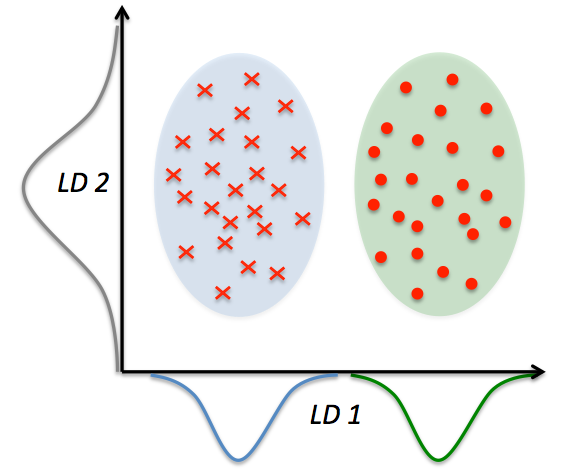

In [25]:
Image(filename='./images/05_06.png', width=400) 

- LD1: would separate the classes very well (and is a good linear discriminant)
- LD2: captures a lot of variance, but would not be a good linear discriminant

#### Derivation [Welling, 2005]

$$
       \max_w \;\; J(w) = \frac{w^T S_B w}{w^T S_W w}
$$

where $S_B$ is the *between-class* scatter matrix, and $S_W$ is the *within-class* scatter matrix:

\begin{align*}
  S_B &= \sum_i^c (m_i - m)(m_i - m)^T \\
  S_W &= \sum_i^c \sum_{x \in D_i} (x - m_i)(x - m_i)^T
\end{align*}

where $m_i$ is the mean of each class and $m$ is the overall mean of the data set.

We can show that the solution satisfies

$$
  S_W^{-1}S_B w = \lambda w 
$$

This is called the *generalized eigenvalue problem*. We can transform this into a regular eigenvalue problem by defining $v := S_B^{1/2}w$ (for $S_B=U\Lambda U^T, S_B^{1/2} = U\Lambda^{1/2} U^T$), to get

$$
  S_B^{1/2}S_W^{-1}S_B^{1/2} v = \lambda v
$$

which is a regular eigenvalue/eigenvector problem.

The linear discrimant directions corresponds to the vectors $w = S_B^{-1/2}v$ where $v$ is the eigenvector associated with the **largest** eigenvalues $\lambda$.

<br>
<br>

## Computing the scatter matrices

Calculate the mean vectors for each class:

$$
 m_i = \frac{1}{N_i} \sum_{x \in D_i} x, \;\; i \in \{1,2,3\}
$$

In [4]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



Compute the within-class scatter matrix:

$$
   S_W = \sum_{i=1}^c S_i
$$

$$
  S_i = \sum_{x\in D_i} (x-m_i)(x-m_i)^T
$$

In [5]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # sum class scatter matrices

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


Better: covariance matrix since classes are not equally distributed:

In [6]:
print('Class label distribution: %s' 
      % np.bincount(y_train)[1:])

Class label distribution: [40 49 35]


Covariance matrix:

$$
  \Sigma_i  = \frac{1}{N_i} S_i = \frac{1}{N_i} \sum_{x\in D_i} (x-m_i)(x-m_i)^T
$$

Scaled within-class scatter matrix:

$$
 S_B = \sum_{i=1}^c \Sigma_i
$$

In [7]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0],
                                                     S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


Compute the *scaled* between-class scatter matrix:

$$
  S_B = \sum_{i=1}^c N_i (m_i-m)(m_i-m)^T
$$

In [8]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13  # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


<br>
<br>

## Selecting linear discriminants for the new feature subspace

Solve the generalized eigenvalue problem for the matrix $S_W^{-1}S_B$:

In [9]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

Sort eigenvectors in decreasing order of the eigenvalues:

In [10]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

452.721581245
156.43636122
1.05646703435e-13
3.99641853702e-14
3.40923565291e-14
2.84217094304e-14
1.4793035293e-14
1.4793035293e-14
1.3494134504e-14
1.3494134504e-14
6.49105985585e-15
6.49105985585e-15
2.65581215704e-15


The first two eigenvalues are positive, and the rest are practically zero.

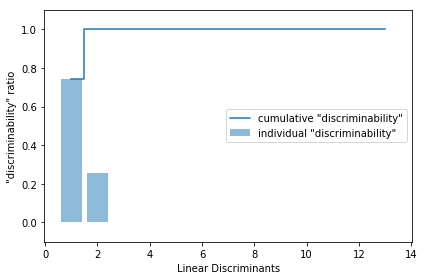

In [11]:
import matplotlib.pyplot as plt

tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/lda1.png', dpi=300)
plt.show()

100% of the useful information ("discriminability") is captured by the top two linear discriminants.

Create the transformation matrix $W$:

In [12]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.0662 -0.3797]
 [ 0.0386 -0.2206]
 [-0.0217 -0.3816]
 [ 0.184   0.3018]
 [-0.0034  0.0141]
 [ 0.2326  0.0234]
 [-0.7747  0.1869]
 [-0.0811  0.0696]
 [ 0.0875  0.1796]
 [ 0.185  -0.284 ]
 [-0.066   0.2349]
 [-0.3805  0.073 ]
 [-0.3285 -0.5971]]


<br>
<br>

## Projecting samples onto the new feature space

$$
 X' = Xw
$$

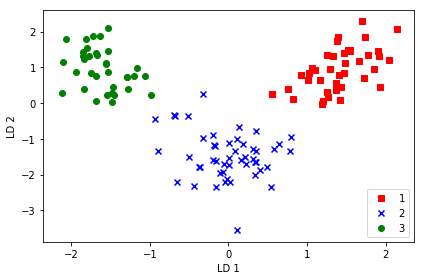

In [13]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0] * (-1),
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('./figures/lda2.png', dpi=300)
plt.show()

<br>
<br>

## LDA via scikit-learn

In [14]:
from sklearn.discriminant_analysis \
  import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

In [15]:
X_train_lda

array([[-5.4023,  0.703 ],
       [ 0.4805, -3.8298],
       [ 4.8024,  3.2049],
       [ 3.3888,  1.0766],
       [-0.7365, -2.0429],
       [ 3.509 ,  0.6611],
       [ 5.2001,  2.4169],
       [-2.9769,  1.2892],
       [ 1.894 , -0.5072],
       [ 4.0399, -0.0524],
       [-0.9032, -3.2456],
       [ 1.7457, -0.6814],
       [ 3.0896,  1.4944],
       [-0.4374, -1.1561],
       [-3.8565,  1.3406],
       [ 2.2749, -2.2956],
       [-1.0281, -2.2011],
       [ 2.4937, -0.8384],
       [-1.5703,  0.4257],
       [-5.328 ,  2.1749],
       [-2.093 , -2.1993],
       [-1.647 , -1.8424],
       [ 5.4537,  1.5216],
       [ 6.1041,  2.0539],
       [ 1.3405, -3.6192],
       [-1.0557, -3.0769],
       [ 0.078 , -3.4616],
       [ 5.1461,  2.6815],
       [ 4.0338,  0.416 ],
       [-3.7436,  0.7626],
       [ 5.1617,  2.2438],
       [-0.0101, -2.8392],
       [ 0.5357, -2.5958],
       [ 0.5581, -1.8796],
       [-0.8274, -2.5175],
       [ 0.2724, -3.1068],
       [-4.5239,  2.0557],
 

In [16]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

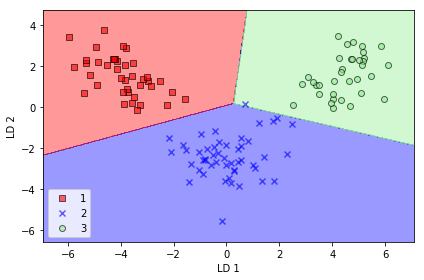

In [17]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./images/lda3.png', dpi=300)
plt.show()

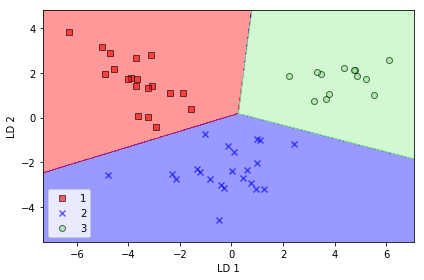

In [18]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./images/lda4.png', dpi=300)
plt.show()

<br>
<br>

# Using kernel PCA for nonlinear mappings

- Many real data points are *not* linearly separable. 
- In such cases, PCA and LDA are not very good choices, since they are essentially linear transformations.

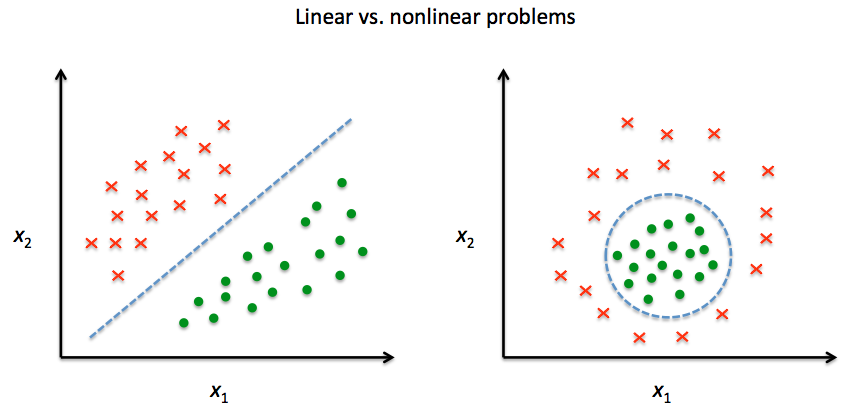

In [39]:
Image(filename='./images/05_11.png', width=500) 

## Kernel functions and the kernel trick

The nonlinear mapping function $\phi: \mathbb{R}^d \to \mathbb{R}^k \;\; (k \gg d)$

In kernel PCA, we will use such mappings to project not linearly separable data points into higher dimensional feature space, and apply the standard PCA in this new feature space.

Recall PCA, where we've considered the covariance matrix of zero-centered data:

$$
  \Sigma = \frac{1}{n} \sum_{i=1}^n x^{(i)} (x^{(i)})^T
$$

Now we consider the PCA not in the original feature space (input space), but in the new space induced by the feature mapping $\phi$:

$$
   \Sigma = \frac{1}{n} \sum_{i=1}^n \phi(x^{(i)}) \phi(x^{(i)})^T
$$

To obtain the principal components $v$, we consider the eigenvalue problem:

$$
         \Sigma_{k\times k} v = \lambda v
$$

$$
 \Rightarrow \frac{1}{n} \sum_{i=1}^n \phi(x^{(i)}) \phi(x^{(i)})^T v = \lambda v
$$

$$
 v = \frac{1}{n\lambda } \sum_{i=1}^n \phi(x^{(i)}) \phi(x^{(i)})^T v = \frac{1}{n} \sum_{i=1}^n a^{(i)} \phi(x^{(i)}) 
$$


where $a^{(i)} = \frac{1}{\lambda} \phi(x^{(i)})^T v$. Since $v$ is the principal component, we can interpret $a^{(i)}$ as the coordinate of $x^{(i)}$ in the induced feature space, projected onto $v$ (in other words, the coordinate we can use for plotting).

We now use $\phi(X)$ to be $n\times k$ matrix, so that

$$
  \Sigma = \frac{1}{n} \phi(X)^T \phi(X)
$$

and the eigenvector equation to be

$$
   v = \frac{1}{n} \phi(X)^T \vec a
$$

From $\Sigma v = \lambda v$, we get

$$
  \frac{1}{n} \phi(X)^T \phi(X) \phi(X)^T \vec a = \lambda \phi(X)^T \vec a
$$

Multiplying $\phi(X)$ on both sides, we obtain

$$
\frac{1}{n} \phi(X) \phi(X)^T \phi(X) \phi(X)^T \vec a = \lambda \phi(X) \phi(X)^T \vec a
$$

$$
 \Rightarrow \frac{1}{n} \underbrace{\phi(X) \phi(X)^T}_{=: K} \vec a = \lambda \vec a
$$

$$
  \frac{1}{n} K_{n\times n}\vec a = \lambda \vec a
$$

Here, $K$ is the kernel matrix, defined by

$$
  K_{ij} = k(x^{(i)}, x^{(j)}) = \phi(x^{(i)})^T \phi(x^{(j)})
$$

- Polynomial kernel
$$
  k(x^{(i)}, x^{(j)}) = ((x^{(i)})^T x^{(j)} + \theta)^p
$$

- Hyperbolic tangent (sigmoid) kernel
$$
  k(x^{(i)}, x^{(j)}) = \tanh(\eta (x^{(i)})^T x^{(j)} + \theta)
$$

- Gaussian RBF kernel
$$
    k(x^{(i)}, x^{(j)}) = \exp(-\gamma \|x^{(i)}-x^{(j)}\|^2)
$$

Before we solve
$$
  \frac{1}{n} K \vec a = \lambda \vec a,
$$

we need center the kernel matrix by (why?)

$$
  K = K - 1_n K - K 1_n + 1_n K 1_n
$$

where $1_n$ is $n\times n$ matrix with all elements equal to $\frac{1}{n}$.


<br>
<br>

## Implementing a kernel principal component analysis in Python

In [19]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from numpy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
       Projected dataset   

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # numpy.linalg.eigh returns them in sorted order
    eigvals, eigvecs = eigh(K)

    # Collect the top k eigenvectors (projected samples)
    X_pc = np.column_stack((eigvecs[:, -i]
                            for i in range(1, n_components + 1)))

    return X_pc

<br>

### Example 1: Separating half-moon shapes

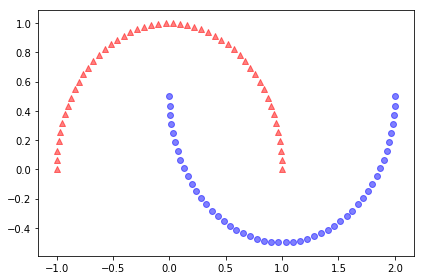

In [20]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('./figures/half_moon_1.png', dpi=300)
plt.show()

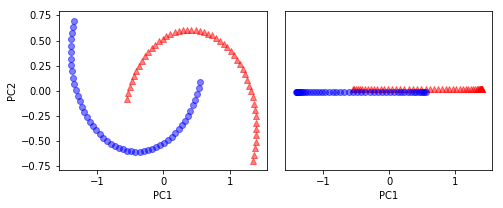

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('./figures/half_moon_2.png', dpi=300)
plt.show()

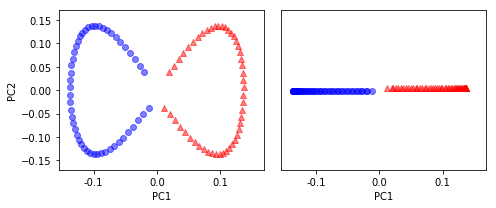

In [28]:
from matplotlib.ticker import FormatStrFormatter

X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02, 
            color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02,
            color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

plt.tight_layout()
# plt.savefig('./figures/half_moon_3.png', dpi=300)
plt.show()

<br>

### Example 2: Separating concentric circles

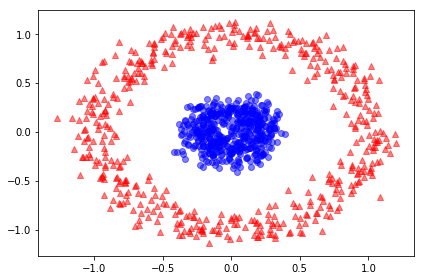

In [29]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('./figures/circles_1.png', dpi=300)
plt.show()

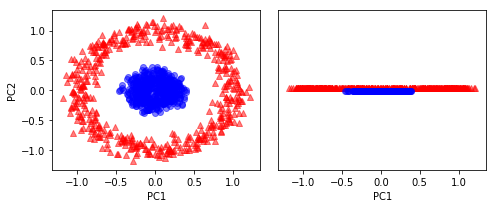

In [30]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('./figures/circles_2.png', dpi=300)
plt.show()

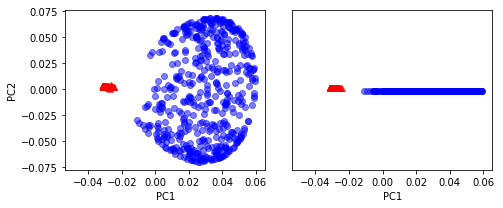

In [36]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('./figures/circles_3.png', dpi=300)
plt.show()

<br>
<br>

## Projecting new data points

To compute the new coordinate of a new point $x'$ along the principal component $v$, we need to compute
$$
  a = \frac{1}{\lambda} \phi(x')^T v .
$$

But in kernel PCA, we do not compute $v$ explicitly.

We can use the kernel trick:

$$
   \phi(x')^T v = \frac{1}{n} \sum_{i=1}^n a^{(i)} \underbrace{\phi(x')^T \phi(x^{(i)})}_{= k(x', x^{(i)})}
$$

Recall: 
$$
   v = \frac{1}{n} \phi(X)^T \vec a
$$

In [47]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
       Projected dataset   
     
     lambdas: list
       Eigenvalues

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # numpy.eigh returns them in sorted order
    eigvals, eigvecs = eigh(K)

    # Collect the top k eigenvectors (projected samples)
    alphas = np.column_stack((eigvecs[:, -i]
                              for i in range(1, n_components + 1)))

    # Collect the corresponding eigenvalues
    lambdas = [eigvals[-i] for i in range(1, n_components + 1)]

    return alphas, lambdas

In [48]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

In [49]:
x_new = X[-1]
x_new

array([ 0.4816, -0.3551])

In [50]:
x_proj = alphas[-1] # original projection
x_proj

array([ 0.1192])

In [51]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# projection of the "new" datapoint
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj 

array([ 0.1192])

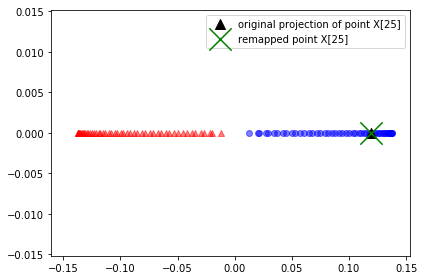

In [52]:
plt.scatter(alphas[y == 0, 0], np.zeros((50)),
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black',
            label='original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green',
            label='remapped point X[25]', marker='x', s=500)
plt.legend(scatterpoints=1)

plt.tight_layout()
# plt.savefig('./figures/reproject.png', dpi=300)
plt.show()

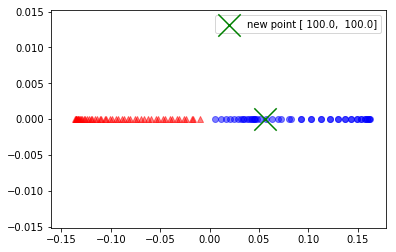

In [53]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X[:-1, :], gamma=15, n_components=1)

def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# projection of the "new" datapoint
x_new = X[-1]

x_reproj = project_x(x_new, X[:-1], gamma=15, alphas=alphas, lambdas=lambdas)


plt.scatter(alphas[y[:-1] == 0, 0], np.zeros((50)),
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y[:-1] == 1, 0], np.zeros((49)),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_reproj, 0, color='green',
            label='new point [ 100.0,  100.0]', marker='x', s=500)
plt.legend(scatterpoints=1)


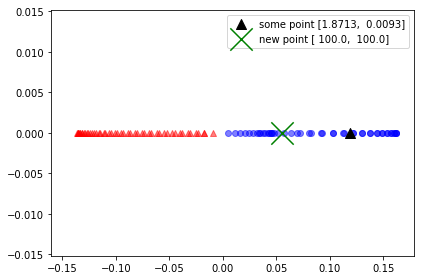

In [54]:
plt.scatter(alphas[y[:-1] == 0, 0], np.zeros((50)),
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y[:-1] == 1, 0], np.zeros((49)),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black',
            label='some point [1.8713,  0.0093]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green',
            label='new point [ 100.0,  100.0]', marker='x', s=500)
plt.legend(scatterpoints=1)

plt.tight_layout()
# plt.savefig('./figures/reproject.png', dpi=300)
plt.show()

<br>
<br>

## Kernel principal component analysis in scikit-learn

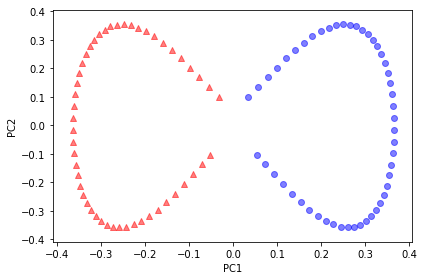

In [55]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
# plt.savefig('./figures/scikit_kpca.png', dpi=300)
plt.show()

<br>
<br>

# Summary

...